In [1]:
import numpy as np
import graspy as gp
import matplotlib.pyplot as plt
from graspy.cluster import AutoGMMCluster
from itertools import product
from joblib import Parallel, delayed
import pickle
import seaborn as sns
%matplotlib inline

from sklearn.metrics import adjusted_rand_score

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [80]:
a = 0.01
b = 0.02
c = 0.0
d = 0.002
e = 0.077
f = 0.002
g = 0.013

# a = 0.01
# b = 0.02
# c = 0.0
# d = 0.002
# e = 0.077
# f = 0.002
# g = 0.013

B = np.array([
    [a, b, c, d],
    [b, e, f, g],
    [c, f, a, b],
    [d, g, b, e]
])

projection1 = np.array([
    [np.mean(B[:2,:2]), np.mean(B[:2,2:])],
    [np.mean(B[:2,2:]), np.mean(B[2:,2:])],
])
print(projection1)

projection2 = np.array([
    [np.mean([a, c, c, a]), np.mean([b, d, f, b])],
    [np.mean([b, d, f, b]), np.mean([e, g, g, e])]
])

print(projection2)

[[0.03175 0.00425]
 [0.00425 0.03175]]
[[0.005 0.011]
 [0.011 0.045]]


In [102]:
n = 4000
np.random.seed(n)
pi = np.array([.25] * 4)
A = gp.simulations.sbm((n * pi).astype(int), B)
LSE_embedding = gp.embed.LaplacianSpectralEmbed('DAD', 2, check_lcc=True).fit_transform(A)
ASE_embedding = gp.embed.AdjacencySpectralEmbed(2, check_lcc=True).fit_transform(A)

gp.utils.is_fully_connected(A)

affinity = ['euclidean','manhattan','none']

affinity_labels = np.array(['AB'] * (n//2) + ['CD'] * (n//2)) #left right
core_labels = np.tile(["AC"] * (n//4) + ["BD"] * (n//4), 2) # gray white

LSE_GMM = AutoGMMCluster(2, 2, affinity=affinity).fit_predict(LSE_embedding, affinity_labels)
ASE_GMM = AutoGMMCluster(2, 2, affinity=affinity).fit_predict(ASE_embedding, core_labels)

In [103]:
LSE_GMM[1]

1.0

In [104]:
ASE_GMM[1]

1.0

In [110]:
block_labels = np.array(['A'] * 1000 + ['B'] * 1000 + ['C'] * 1000 + ['D'] * 1000)

In [112]:
from matplotlib.patches import Ellipse

(0.006187055271034361, 0.02354781598662807) (-0.022654753392707064, 0.02382899319400503)
(0.007135504331791515, 0.2954339440223153) (-0.2784986391496291, 0.2921274055098727)


Text(0.5, 1.0, 'Adjacency Spectral Embedding')

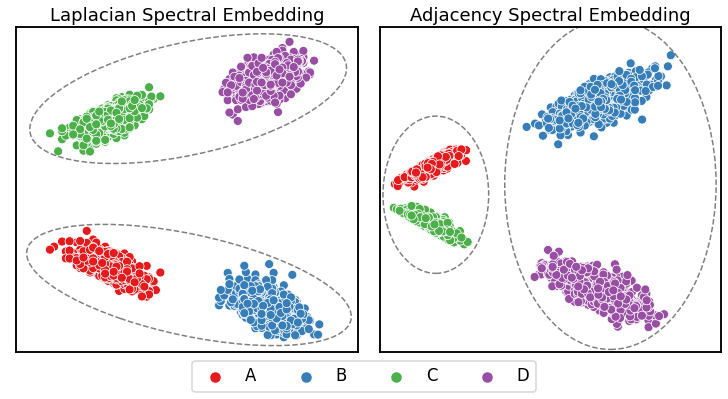

In [217]:
palette = ['#e41a1c','#377eb8','#4daf4a','#984ea3']


sns.set_context('talk')
fig, ax = plt.subplots(1, 2, 
                       #sharex=True, 
                       #sharey=True, 
                       figsize=(10, 5), constrained_layout=True)
sns.scatterplot(
    LSE_embedding[:, 0], 
    LSE_embedding[:, 1], 
    hue=block_labels,
    palette= palette,
    ax=ax[0]
)
sns.scatterplot(
    ASE_embedding[:, 0], 
    ASE_embedding[:, 1], 
    palette = palette,
    hue=block_labels, 
    ax=ax[1]
)

for a in ax:
    #a.axis('off')
    a.set_xticks([])
    a.set_yticks([])
    handles, labels = a.get_legend_handles_labels()
    a.get_legend().remove()
    
    
# Deal with legends
handles, labels = ax[0].get_legend_handles_labels()
legend = fig.legend(
    handles, 
    ['A', 'B', 'C', 'D'],
    ncol = 4, 
    loc='lower center',
    bbox_to_anchor=(.5, -0.1),
    bbox_transform=plt.gcf().transFigure
)
    
    
# Make ellipses
ells = [
    Ellipse([0.01507347, 0.01358524], .0225, .0135, 45, ls='--', fill=False),
    Ellipse([ 0.01512061, -0.01306383], .0225, .0125, -40, ls='--', fill=False),
]
for e in ells:
    e.set_clip_box(ax[0].bbox)
    e.set_alpha(0.5)
    ax[0].add_artist(e)
    

ells = [
    Ellipse([6.0004e-02, 9.52094075e-05], .1, .3, 0, ls='--', fill=False),
    Ellipse([ 0.22518965 , 0.02], .2, .63, 0, ls='--', fill=False),
]
for e in ells:
    e.set_clip_box(ax[0].bbox)
    e.set_alpha(0.5)
    ax[1].add_artist(e)

for i in ax:
    print(i.get_xlim(), i.get_ylim())
    
    
ax[0].set_xlim(0.005, 0.025)
ax[1].set_xlim(0.007, 0.33)
ax[1].set_ylim(-.3, .32)

ax[0].set_title("Laplacian Spectral Embedding")
ax[1].set_title("Adjacency Spectral Embedding")


In [218]:
fig.savefig("two_truths.pdf", bbox_inches='tight')